# TODO

- Visualization
    - Color bar 
    - Line graph
- from, to point 정의 (Right)

- Point, Point가 점유하는 공간

- sulcus 추가
- hemisphere 동시 표현
- 양쪽으로 펼치기

# Common Libraries

In [1]:
import os
import numpy as np
import nibabel as nb
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from glob import glob
from scipy.stats import ttest_1samp
from nilearn.plotting import plot_surf_roi
from copy import copy
from scipy.stats import sem
import seaborn as sns
from scipy.stats import ttest_1samp
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Custom Libraries

In [2]:
import sys

sys.path.append("/home/seojin")
sys.path.append("/home/seojin/Seojin_commonTool/Module")
import surfAnalysisPy as surf
from surface_analysis import vol_to_surf, surface_cross_section, surf_paths, gaussian_weighted_smoothing, load_surfData_fromVolume
from surface_analysis import surf_paths, show_both_hemi_sampling_coverage, show_both_hemi_images
from sj_matplotlib import draw_ticks, draw_spine, draw_label
from sj_math import round_down

# Params

In [3]:
surf_resolution = 32

# Nifti image paths
volume_data_dir_path = "/mnt/ext1/seojin/HR/exp_blueprint_0324v4/fMRI_data/output/Group/rsa/rdm/set/WholeSet/base_seqOnly/None/pattern_separation"
volume_data_paths = sorted(glob(volume_data_dir_path + "/*crossnobis*"))

# ROI
atlas = "Brodmann"

# For cross-section analysis (virtual strip)
L_from_point = np.array([-24, 111])  
L_to_point = np.array([81, 47])    

R_from_point = np.array([23, 80])
R_to_point = np.array([-75, 22]) 
    
width = 20
cross_section_n_sampling = 30

# Paths
save_dir_path = "/mnt/ext1/seojin/temp"

# Constants

In [4]:
l_surf_info = surf_paths("L")
r_surf_info = surf_paths("R")

# Functions

In [5]:
def do_smoothing(volume_data_paths, hemisphere, sigma = 2.0):
    surf_data = load_surfData_fromVolume(volume_data_paths, hemisphere = hemisphere)

    template_path = surf_paths(hemisphere)[f"{hemisphere}_template_surface_path"]
    temploate_surface_data = nb.load(template_path)
    vertex_locs = temploate_surface_data.darrays[0].data[:, :2]

    mean_data = np.mean(surf_data, axis = 1)
    smoothed_data = gaussian_weighted_smoothing(coords = vertex_locs, 
                                                values = mean_data, 
                                                sigma = sigma)

    return smoothed_data

# Volume to Surface

In [6]:
# Load surf datas
l_surf_data = load_surfData_fromVolume(volume_data_paths, hemisphere = "L")
r_surf_data = load_surfData_fromVolume(volume_data_paths, hemisphere = "R")

# Smoothing
l_smoothed_data = do_smoothing(volume_data_paths, hemisphere = "L")
r_smoothed_data = do_smoothing(volume_data_paths, hemisphere = "R")

# Cross section analysis

In [7]:
l_cross_section_result_info = surface_cross_section(template_surface_path = l_surf_info["L_template_surface_path"],
                                                    surface_data = l_surf_data,
                                                    from_point = L_from_point,
                                                    to_point = L_to_point,
                                                    width = width,
                                                    n_sampling = cross_section_n_sampling)

r_cross_section_result_info = surface_cross_section(template_surface_path = r_surf_info["R_template_surface_path"],
                                                    surface_data = r_surf_data,
                                                    from_point = R_from_point,
                                                    to_point = R_to_point,
                                                    width = width,
                                                    n_sampling = cross_section_n_sampling)

# Virtual strip
l_virtual_stip_mask = l_cross_section_result_info["virtual_stip_mask"]
r_virtual_stip_mask = r_cross_section_result_info["virtual_stip_mask"]

In [8]:
import imp
import surface_analysis
imp.reload(surface_analysis)

from surface_analysis import show_both_hemi_sampling_coverage, get_bounding_box, show_surf_withGrid, show_sulcus, detect_sulcus, detect_roi_names

/tmp/ipykernel_3297834/1435427917.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


# Bounding box

In [9]:
left_bounding_box = get_bounding_box("L", l_virtual_stip_mask)
right_bounding_box = get_bounding_box("R", r_virtual_stip_mask)

# Cross-section analysis coverages

save: /mnt/ext1/seojin/temp/L_hemi_coverage.png
save: /mnt/ext1/seojin/temp/R_hemi_coverage.png
save: /mnt/ext1/seojin/temp/both_hemi_coverage.png.png


<Figure size 640x480 with 0 Axes>

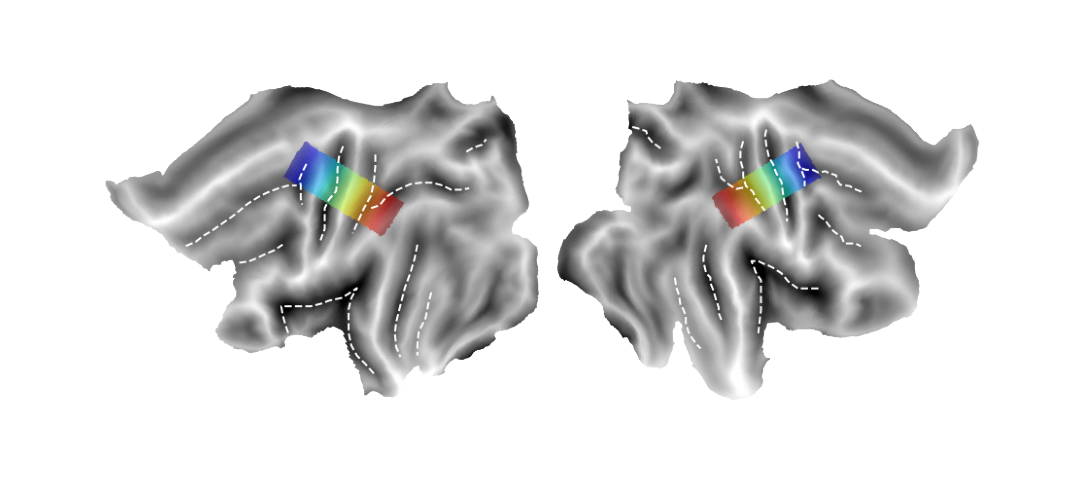

In [10]:
show_both_hemi_sampling_coverage(l_sampling_coverage = l_cross_section_result_info["sampling_coverages"],
                                 r_sampling_coverage = r_cross_section_result_info["sampling_coverages"],
                                 save_dir_path = save_dir_path,
                                 surf_resolution = surf_resolution)

# Visualization threshold

In [11]:
l_t_stat = ttest_1samp(l_surf_data, axis = 1, popmean = 0)
r_t_stat = ttest_1samp(r_surf_data, axis = 1, popmean = 0)

# threshold
threshold = np.mean(np.r_[l_smoothed_data[l_t_stat.pvalue < 0.05], r_smoothed_data[r_t_stat.pvalue < 0.05]])
threshold = round_down(threshold, 4)

# max scale
max_scale = np.mean(np.r_[l_smoothed_data[l_t_stat.pvalue < 0.00001], r_smoothed_data[r_t_stat.pvalue < 0.00001]])
max_scale = round_down(max_scale, 4)

# Show brain figures

In [12]:
is_focusing = False

In [13]:
from surface_analysis import show_both_hemi_stats

save: /mnt/ext1/seojin/temp/L_hemi_stat.png
save: /mnt/ext1/seojin/temp/R_hemi_stat.png
save: /mnt/ext1/seojin/temp/colorbar.png
save: /mnt/ext1/seojin/temp/Both_hemi_stat.png.png


<Figure size 640x480 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

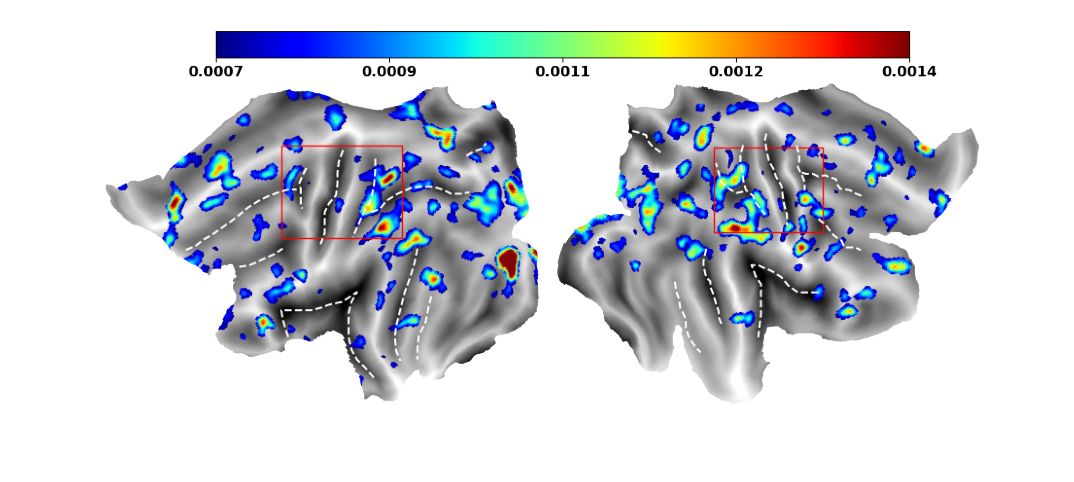

In [14]:
fig, axis = show_both_hemi_stats(l_stat = l_smoothed_data,
                                 r_stat = r_smoothed_data,
                                 threshold = threshold,
                                 cscale = (threshold, max_scale),
                                 save_dir_path = save_dir_path,
                                 left_bounding_box = left_bounding_box,
                                 right_bounding_box = right_bounding_box)

In [15]:
left_bounding_box

{'left_bottom': (-33.670013, 31.466553),
 'width': 124.573944,
 'height': 95.28895}

# Detect sulcus

In [203]:
l_sulcus_names = detect_sulcus("L", l_cross_section_result_info["sampling_coverages"], False)
r_sulcus_names = detect_sulcus("R", r_cross_section_result_info["sampling_coverages"], False)
r_sulcus_names[0] = ""

# Detect roi name

In [243]:
def get_rois(hemisphere):
    if hemisphere == "L":
        cross_section_result_info = l_cross_section_result_info
    else:
        cross_section_result_info = r_cross_section_result_info
        
    rois = detect_rois(cross_section_result_info["sampling_coverages"], hemisphere)
    rois = [roi.replace("|", "") for roi in rois]
    rois = np.array([roi.replace(f"{hemisphere}_", "") for roi in rois])
    rois[np.where(rois == "2")[0]] = "1+2+3"
    rois = np.where(rois == "1+2+3", "3+1+2", rois)
    rois = np.array([roi.replace("+", ", ") for roi in rois])

    return rois

In [221]:
def sulcus_abbreviation_name(sulcus_name):
    if sulcus_name == "Precentral sulcus":
        return "Pre-CS"
    elif sulcus_name == "Central sulcus":
        return "CS"
    elif sulcus_name == "Post central sulcus":
        return "Post-CS"
    elif sulcus_name == "Intra parietal sulcus":
        return "IPS"

In [248]:
p_threshold = 0.05

stat_result = ttest_1samp(sampling_datas, popmean = 0, axis = 1)
significant_indexes = np.where(stat_result.pvalue < p_threshold)[0]

NameError: name 'sampling_datas' is not defined

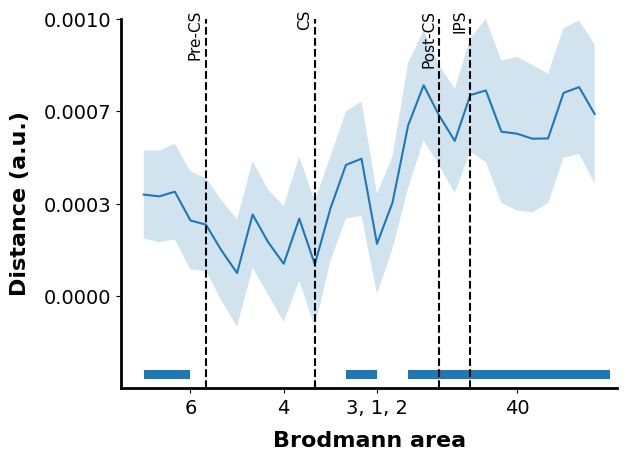

In [222]:
fig, axis = plt.subplots(1)

xs = np.arange(cross_section_n_sampling).astype(str)
indexes = np.where(sulcus_names != "")[0]
sulcuses = sulcus_names[indexes]

# Plot
mean_values = np.mean(sampling_datas, axis = 1)
axis.plot(xs, mean_values)

errors = sem(sampling_datas, axis = 1)
axis.fill_between(xs,
                  mean_values - errors, mean_values + errors, 
                  alpha = 0.2)

"""
for i, data in enumerate(sampling_datas):
    sns.stripplot(x=i, y=data, alpha=0.2, color = "black")
"""

# Set ticks
min_ = 0
max_ = np.max(mean_values + errors)

n_div = 3 
interval = (min_ + max_) / n_div
y_data = np.arange(min_, max_ + interval, interval)

"""
# Draw roi
unique_rois = np.unique(rois)
roi_start_indexes = np.array(sorted([list(rois).index(roi) for roi in unique_rois])) # Select start index of ROI
roi_start_indexes = roi_start_indexes[1:]
for roi_start_i in roi_start_indexes:
    axis.axvline(x = roi_start_i, color = "black", linestyle = "dashed")
"""

# Draw spines
draw_spine(axis)

# Draw labels
label_info = {}
label_info["x_label"] = "Brodmann area"
label_info["y_label"] = "Distance (a.u.)"
draw_label(axis, label_info)
plt.ylim(min_ - interval, max_)

# Sulcus
sulcus_indexes = np.where(sulcus_names != "")[0]
for sulcus_i in sulcus_indexes:
    sulcus_name = sulcus_names[sulcus_i]
    
    axis.axvline(x = sulcus_i, color = "black", linestyle = "dashed")
    axis.text(x = sulcus_i - 0.2, 
              y = max_ + (interval/10), 
              s = sulcus_abbreviation_name(sulcus_name),  
              va = "top", 
              ha = "right",
              size = 11,
              rotation = 90)

# Show significant areas
rect_height = interval / 10
for sig_i in significant_indexes:
    axis.add_patch(Rectangle(xy = (sig_i, min_ - interval + rect_height), width = 1, height = rect_height))

tick_info = {}
tick_info["x_data"] = np.arange(len(rois))
tick_info["x_names"] = rois
tick_info["x_tick_rotation"] = 0
tick_info["y_data"] = y_data
tick_info["y_names"] = y_data
draw_ticks(axis, tick_info)

y_tick_round = 4
axis.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.{y_tick_round}f}"))

# Surf ROI

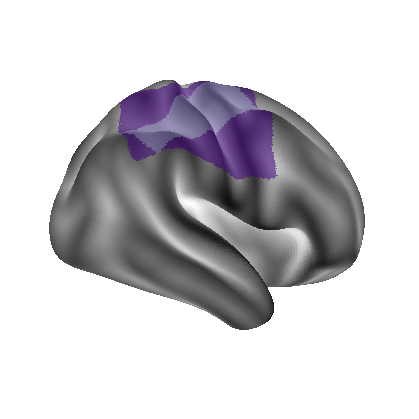

In [162]:
fig = plot_surf_roi(surf_mesh = inflated_brain_path,
                    roi_map = np.where(virtual_stip_mask, 0.7, np.where(is_within_rectangle, 1, 0)),
                    bg_map = shape_gii_path,
                    hemi = "left" if surf_hemisphere == "L" else "right",
                    cmap='Purples',
                    alpha = 2, 
                    vmax = 1, # 1.4, 3
                    bg_on_data = True,
                    darkness = 1.0
)

- 